In [ ]:
import pandas as pd 
from medpy.metric import dc, hd, hd95
import numpy as np

def get_mask_from_RLE(rle, height, width):
    runs = np.array([int(x) for x in rle.split()])
    starts = runs[::2]
    lengths = runs[1::2]

    mask = np.zeros((height * width), dtype=np.uint8)

    for start, length in zip(starts, lengths):
        start -= 1  
        end = start + length
        mask[start:end] = 255

    mask = mask.reshape((height, width))
    
    return mask

physician_annotations = "martina_annotations.csv"
df = pd.read_csv(physician_annotations)
datasets = df["Dataset"].unique()

new_df = pd.DataFrame(columns=["Dataset", "ImageID", "Dice GT", "Dice RCA (Max)", "Dice RCA (Mean)", 
                               "Dice Lungs", "Dice Heart", "Hausdorff Lungs", "Hausdorff Heart", "Hausdorff 95 Lungs", "Hausdorff 95 Heart"])


count = 0
imageslist = []
shapes = []

for dataset in datasets:
    annotations = df[df["Dataset"] == dataset]
    segmentations = pd.read_csv("Subsets/" + dataset + ".csv")
    column_id = segmentations.columns[0]
    segmentations = segmentations.rename(columns={column_id: "ImageID"})
    
    images = annotations.ImageID.unique()
    
    for image in images:
        pred_row = segmentations[segmentations["ImageID"] == image]
        gt_row = annotations[annotations["ImageID"] == image]
                
        RL = pred_row["Right Lung"].values[0]
        LL = pred_row["Left Lung"].values[0]
        H = pred_row["Heart"].values[0]
        
        RL = get_mask_from_RLE(RL, 1024, 1024)
        LL = get_mask_from_RLE(LL, 1024, 1024)
        Lungs = np.logical_or(RL, LL)
        H = get_mask_from_RLE(H, 1024, 1024)
        
        GT_RL = gt_row["Right Lung"].values[0]
        GT_LL = gt_row["Left Lung"].values[0]
        GT_H = gt_row["Heart"].values[0]
        
        GT_RL = get_mask_from_RLE(GT_RL, 1024, 1024)
        GT_LL = get_mask_from_RLE(GT_LL, 1024, 1024)
        GT_Lungs = np.logical_or(GT_RL, GT_LL)
        GT_H = get_mask_from_RLE(GT_H, 1024, 1024)
        
        GT_Landmarks = np.array(eval(gt_row["Landmarks"].values[0])).astype(np.float32).reshape(-1, 2)
        PRED_Landmarks = np.array(eval(pred_row["Landmarks"].values[0])).astype(np.float32).reshape(-1, 2)
        
        MSE = np.mean(np.square(GT_Landmarks - PRED_Landmarks))
        
        dice_lungs = dc(Lungs, GT_Lungs)
        Hausdorff_lungs = hd(Lungs, GT_Lungs)
        Hausdorff_95_lungs = hd95(Lungs, GT_Lungs)
        
        dice_h = dc(H, GT_H)
        Hausdorff_h = hd(H, GT_H)
        Hausdorff_95_h = hd95(H, GT_H)
        
        dice_avg = (dice_lungs + dice_h) / 2
        dice_rca_max = pred_row["Dice RCA (Max)"].values[0]
        dice_rca_mean = pred_row["Dice RCA (Mean)"].values[0]
        
        new_df = new_df.append({"Dataset": dataset, "ImageID": image, "Dice GT": dice_avg, "MSE": MSE,
                                "Dice RCA (Max)": dice_rca_max, "Dice RCA (Mean)": dice_rca_mean,
                                "Dice Lungs": dice_lungs, "Dice Heart": dice_h, "Hausdorff Lungs": Hausdorff_lungs, "Hausdorff Heart": Hausdorff_h,
                                "Hausdorff 95 Lungs": Hausdorff_95_lungs, "Hausdorff 95 Heart": Hausdorff_95_h}, ignore_index=True)


new_df.to_csv("martina_eval.csv", index=False)

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Load the data
df = pd.read_csv("martina_eval.csv")

# Plotting dice, Hausdorff, and Hausdorff 95 for lungs and heart
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
sns.boxplot(x="Dataset", y="Dice Lungs", data=df, ax=axes[0, 0])
axes[0, 0].set_title("Dice for Lungs")
sns.boxplot(x="Dataset", y="Dice Heart", data=df, ax=axes[0, 1])
axes[0, 1].set_title("Dice for Heart")
sns.boxplot(x="Dataset", y="Hausdorff Lungs", data=df, ax=axes[1, 0])
axes[1, 0].set_title("Hausdorff for Lungs")
sns.boxplot(x="Dataset", y="Hausdorff Heart", data=df, ax=axes[1, 1])
axes[1, 1].set_title("Hausdorff for Heart")

plt.tight_layout()
plt.show()

# Compare True DSC average with estimation values from RCA
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
sns.scatterplot(x="Dice GT", y="Dice RCA (Max)", data=df, ax=axes[0])
axes[0].set_title("Dice GT vs. Dice RCA (Max)")
sns.scatterplot(x="Dice GT", y="Dice RCA (Mean)", data=df, ax=axes[1])
axes[1].set_title("Dice GT vs. Dice RCA (Mean)")

plt.tight_layout()
plt.show()


In [7]:
import pandas as pd
import numpy as np

# Load the data
results = pd.read_csv("martina_eval.csv")

results = results.drop(columns=["ImageID", "Dice GT", "Dice RCA (Max)", "Dice RCA (Mean)"])

# Sort columns first lungs, then heart
results=results[["Dataset", "Dice Lungs", "Hausdorff Lungs", "Hausdorff 95 Lungs", "Dice Heart", "Hausdorff Heart", "Hausdorff 95 Heart"]]

# Group by dataset and compute mean and standard deviation
final_results = results.groupby("Dataset").agg(['mean', 'std'])

# Display results
final_results = final_results.round(3)

# round HD and HD95 mean and std to 1 decimal
final_results[("Hausdorff Lungs", "mean")] = final_results[("Hausdorff Lungs", "mean")].round(1)
final_results[("Hausdorff Lungs", "std")] = final_results[("Hausdorff Lungs", "std")].round(1)
final_results[("Hausdorff 95 Lungs", "mean")] = final_results[("Hausdorff 95 Lungs", "mean")].round(1)
final_results[("Hausdorff 95 Lungs", "std")] = final_results[("Hausdorff 95 Lungs", "std")].round(1)
final_results[("Hausdorff Heart", "mean")] = final_results[("Hausdorff Heart", "mean")].round(1)
final_results[("Hausdorff Heart", "std")] = final_results[("Hausdorff Heart", "std")].round(1)
final_results[("Hausdorff 95 Heart", "mean")] = final_results[("Hausdorff 95 Heart", "mean")].round(1)
final_results[("Hausdorff 95 Heart", "std")] = final_results[("Hausdorff 95 Heart", "std")].round(1)

display(final_results)


Dice Lungs        Hausdorff Lungs       Hausdorff 95 Lungs  \
                    mean    std            mean   std               mean   
Dataset                                                                    
CANDID-PTX         0.981  0.038            23.7  43.0               11.9   
CheXpert           0.947  0.087            39.3  57.7               27.0   
ChestX-Ray8        0.961  0.097            32.3  63.4               18.8   
MIMIC-CXR-JPG      0.965  0.077            29.7  51.1               15.1   
Padchest           0.966  0.089            23.0  42.7               12.7   
VinDr-CXR          0.978  0.048            18.8  40.1                8.9   

                    Dice Heart        Hausdorff Heart        \
                std       mean    std            mean   std   
Dataset                                                       
CANDID-PTX     23.6      0.950  0.111            23.6  51.9   
CheXpert       46.3      0.961  0.083            18.0  37.2   
ChestX-Ray8    44.1      0.958  0.133            18.6  58.6   
MIMIC-CXR-JPG  32.2      0.954  0.101            22.9  51.9   
Padchest       27.5      0.980  0.035            12.8  24.3   
VinDr-CXR      18.5      0.953  0.119            21.9  55.4   

              Hausdorff 95 Heart        
                            mean   std  
Dataset                                 
CANDID-PTX                  21.0  46.6  
CheXpert                    14.8  30.3  
ChestX-Ray8                 17.2  55.1  
MIMIC-CXR-JPG               21.2  47.8  
Padchest                    10.4  18.8  
VinDr-CXR                   20.6  52.6

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import linregress, pearsonr

# Define a function to create a correlation plot
def create_corr_plot(y_col, x_col, data, x_name, y_name):
    sns.set(style='whitegrid')
    
    # Perform linear regression
    slope, intercept, r_value, _, _ = linregress(data[x_col], data[y_col])

    # Calculate Pearson coefficient
    pearson_coeff, _ = pearsonr(data[x_col], data[y_col])

    # Create a scatter plot
    sns.scatterplot(x=x_col, y=y_col, data=data)

    # Plot the fitted line
    x = data[x_col]
    y = slope * x + intercept
    
    if intercept > 0:
        plt.plot(x, y, color='red', label=f'y = {slope:.2f}*x + {intercept:.2f}\nPearson: {pearson_coeff:.2f}')
    else:
        plt.plot(x, y, color='red', label=f'y = {slope:.2f}*x - {abs(intercept):.2f}\nPearson: {pearson_coeff:.2f}')
        
    # Draw [0,0], [1,1] lines
    plt.plot([0.4, 1], [0.4, 1], color='black', linestyle='--', linewidth=1, label='y=x')
    
    plt.xlabel(x_name)
    plt.ylabel(y_name)
    
    plt.xlim(0.4, 1)
    plt.ylim(0.4, 1)
    
    # Customize plot
    plt.title(f'Correlation plot: {x_name} vs {y_name}')
    plt.legend()
    
    
# Define a function to create a correlation plot
def create_corr_plot_datasets(y_col, x_col, data, x_name, y_name):
    sns.set(style='whitegrid')
    
    # Perform linear regression
    slope, intercept, r_value, _, _ = linregress(data[x_col], data[y_col])

    # Calculate Pearson coefficient
    pearson_coeff, _ = pearsonr(data[x_col], data[y_col])

    # Create a scatter plot
    sns.scatterplot(x=x_col, y=y_col, data=data, hue="Dataset")

    # Plot the fitted line
    x = data[x_col]
    y = slope * x + intercept
    
    if intercept > 0:
        plt.plot(x, y, color='red', label=f'y = {slope:.2f}*x + {intercept:.2f}\nPearson: {pearson_coeff:.2f}')
    else:
        plt.plot(x, y, color='red', label=f'y = {slope:.2f}*x - {abs(intercept):.2f}\nPearson: {pearson_coeff:.2f}')
        
    # Draw [0,0], [1,1] lines
    plt.plot([0.4, 1], [0.4, 1], color='black', linestyle='--', linewidth=1, label='y=x')
    
    plt.xlabel(x_name)
    plt.ylabel(y_name)
    
    plt.xlim(0.4, 1)
    plt.ylim(0.4, 1)
    
    ax = plt.gca()
    handles, labels = ax.get_legend_handles_labels()
    
    ax.add_artist(plt.legend(handles[0:6], labels[0:6], loc='lower right'))
    ax.add_artist(plt.legend(handles[6:], labels[6:], loc='upper left'))
    
    # Customize plot
    plt.title(f'Correlation plot: {x_name} vs {y_name}')


df_rca = pd.read_csv('df_rca_affine_deformable_lh.csv')

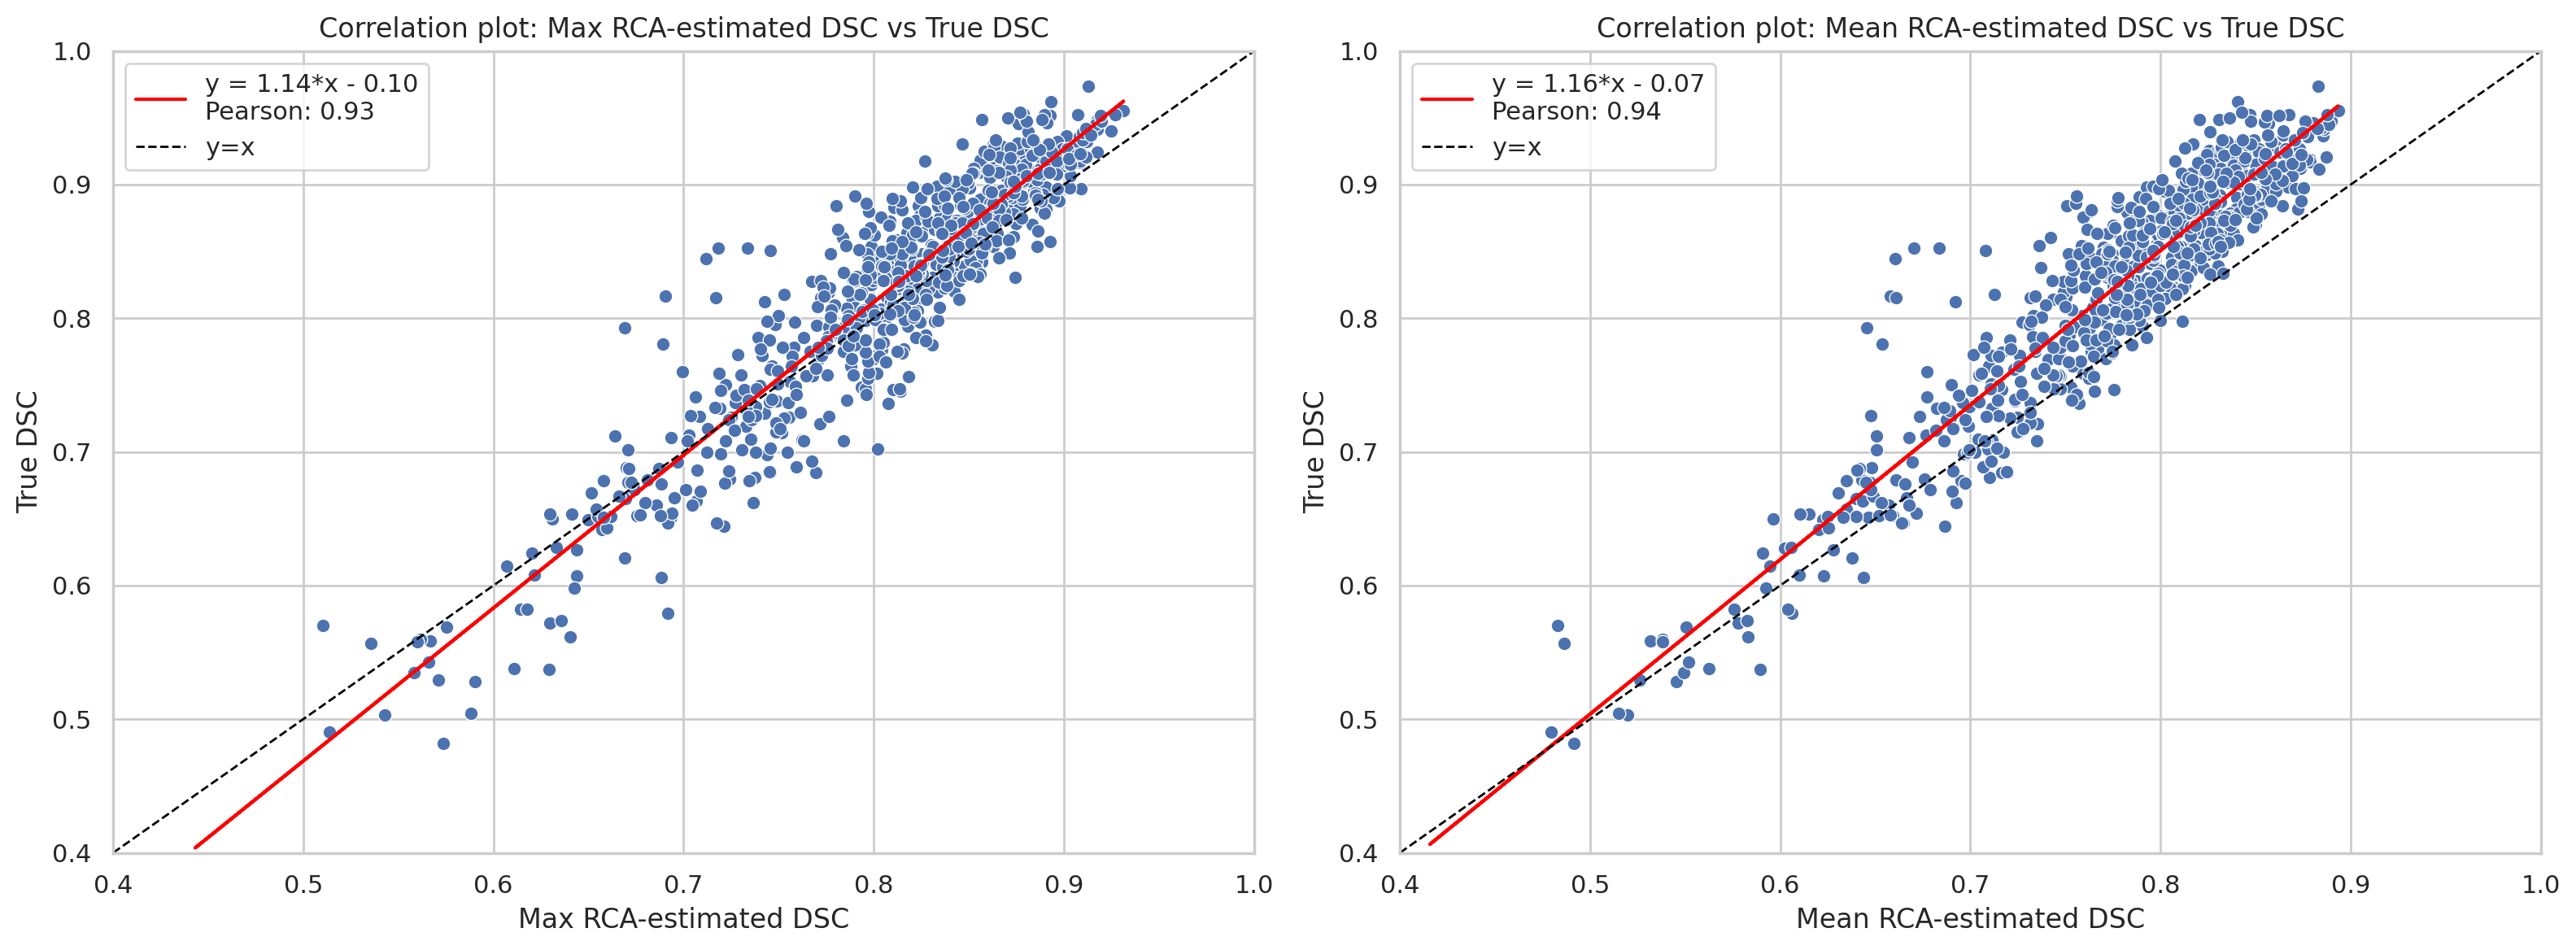

In [3]:
plt.subplots(figsize=(16, 6), dpi=200)

# First row
plt.subplot(1, 2, 1)
create_corr_plot("Dice_Real", "Dice_RCA_Max", df_rca, 'Max RCA-estimated DSC', 'True DSC')

plt.subplot(1, 2, 2)
create_corr_plot("Dice_Real", "Dice_RCA_Mean", df_rca, 'Mean RCA-estimated DSC', 'True DSC')

# Suptitle for the first row
# plt.suptitle('RCA-estimated DSC on Chest X-ray Landmark Dataset', fontsize=16)

plt.tight_layout()
plt.savefig('rca_chest_landmark.pdf', dpi=200)